<a href="https://colab.research.google.com/github/andy311p/format/blob/master/statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A simulation of two competing companies
One of the best ways to evaluate the efficacy of a statistical approach is to perform a Monte Carlo simulation on synthetic data.

So, let’s simulate a company that makes decisions based on the mean competing against a company that makes decisions based on the median.

A *relatively* simple business decision we can simulate is an A/B test. In an A/B test, a company faces the decision of releasing two different versions (variants) of a product — A and B.

For simplicity, we will simulate this as a “winner take all” test, meaning that the companies choose the variant that appears better from the test without calculating statistical significance. **This approach is reasonable when there is no control group, and the business question is relatively low risk.**

Before releasing variant A or B to the entire customer base, the company tests variant A with a sample of customers and variant B with a different sample of customers.

Based on the performance of variants A and B in the test, the company chooses to release either variant A or variant B to the entire customer base.

Here is a summary of the setup. On each simulation:

1.   We will randomly generate two skewed distributions. These distributions represent the true distributions for the revenue per user for variants A and B.
2.   To decide which variant to release, the companies will analyze a dataset consisting of 1,000 draws from variant A’s distribution and 1,000 draws from variant B’s distribution. These draws comprise the “test dataset.”
3. To isolate the impact of the decision-making approach, both companies analyze the same A/B test dataset.
4. Each company will choose either A or B based on the test dataset.
5. After choosing a variant, each company launches its preferred variant “at scale” to its entire customer base. We will simulate this step by generating 100,000 draws from each company’s chosen distribution. These draws represent the revenue received from each company’s 100,000 customers.
6. The business objective is to maximize the total revenue, so we will evaluate each company’s decision-making policy based on each company's total revenue when it releases its preferred variant at scale.

Now let’s get into the Python implementation. The full implementation is available on: https://github.com/tbuffington7/a-tale-of-two-companies/blob/main/simulation.ipynb . I encourage readers to experiment with it to understand how different decision-making frameworks lead to different business outcomes.

First, we need to write a function that generates random skewed distribution. I chose log-normal distributions as they are a common model for skewed data.

Recall that if a variable x has a log-normal distribution, log(x) has a normal distribution. I find it intuitive to characterize the parameters of the log-normal distribution based on the mean (mu) and the standard deviation (sigma) of the underlying normal distribution.

In this function, we randomly draw mu from a uniform distribution between 0 and 0.5 and draw sigma from a uniform distribution between 1 and 1.5:

In [173]:
import numpy as np
from scipy import stats
from tqdm import tqdm
np.random.seed(777)
#generate a random log-normal distribution
def generate_random_lognorm(mu_min=0, mu_max=0.5, sigma_min=1, sigma_max=1.5):
  mu_random = np.random.uniform(mu_min,mu_max)
  sigma_random = np.random.uniform(sigma_min,sigma_max)
  random_distribution = stats.lognorm(s=sigma_random,scale=np.exp(mu_random))
  return(random_distribution)

# #generate N different distributions
# distributions = []
# x = np.linspace(0,10,400)
# for _ in range(5):
#   distribution = generate_random_lognorm()
#   plt.plot(x,distribution.pdf(x))
# plt.show()

# #generate 1000 samples of two random distributions
# def generate_plt(x):
#   plt.xlabel("revenue per customer")
#   plt.ylabel("count")
#   plt.xlim(0,100)
#   plt.ylim(0,1000)
#   plt.hist(x,np.linspace(0,100,20))

# dist1 = generate_random_lognorm()
# x1 = dist1.rvs(1000)
# plt.subplot(1,2,1)
# generate_plt(x1)

# dist2 = generate_random_lognorm()
# x2 = dist2.rvs(1000)
# plt.subplot(1,2,2)
# generate_plt(x2)

#Running 5000 simulations
def decide_by_mean(data_sample_1,data_sample_2):
  if np.mean(data_sample_1) >= np.mean(data_sample_2):
    return("Distribution_1")
  else:
    return("Distribution_2")

def decide_by_median(data_sample_1,data_sample_2):
  if np.median(data_sample_1) >= np.median(data_sample_2):
    return("Distribution_1")
  else:
    return("Distribution_2")

num_of_simulations = 5000
num_draws_at_scale = 100000
num_samples = 1000
company_policy = {'Mean':decide_by_mean,
                  'Median':decide_by_median}
companies = list(company_policy.keys())
selections = {company:[] for company in companies}
rewards = {company:[] for company in companies}
for i in tqdm(range(num_of_simulations)):
  dist1 = generate_random_lognorm()
  dist2 = generate_random_lognorm()

  x1 = dist1.rvs(num_samples)
  x2 = dist2.rvs(num_samples)

  for company in companies:
    chosen_distribution = company_policy[company](x1,x2)
    selections[company].append(chosen_distribution)
    if chosen_distribution == 'Distribution_1':
      reward = np.sum(dist1.rvs(num_draws_at_scale))
    else:
      reward = np.sum(dist2.rvs(num_draws_at_scale))
    rewards[company].append(reward)

# #plot distribution of total reveniew (PDF)
# for company in companies:
#   plt.hist(rewards[company],bins=20,histtype='step',label=company)
# plt.xlabel("Total reveniew")
# plt.ylabel("Density")
# plt.legend()

# how much agreement between Mean and Median
mask = [a==b for a,b in zip(selections['Mean'],selections['Median'])]
print("Agreement rate: {}%".format(np.sum(mask)/num_of_simulations * 100))
# when there is disagreement, how often is Mean better
mask2 = [mean >= median for m,(mean,median) in zip(mask,zip(rewards['Mean'],rewards['Median'])) if m==False]
print("Mean win when disagree: {}%".format(round(np.sum(mask2) / len(mask2) * 100,2)))

100%|██████████| 5000/5000 [01:07<00:00, 74.21it/s]


Agreement rate: 71.48%
Mean win when disagree: 87.94%


(array([62., 46., 47., 43., 55., 52., 46., 60., 47., 49., 59., 41., 54.,
        49., 43., 37., 46., 56., 46., 62.]),
 array([9.96872220e-03, 5.08100725e-01, 1.00623273e+00, 1.50436473e+00,
        2.00249673e+00, 2.50062874e+00, 2.99876074e+00, 3.49689274e+00,
        3.99502475e+00, 4.49315675e+00, 4.99128875e+00, 5.48942075e+00,
        5.98755276e+00, 6.48568476e+00, 6.98381676e+00, 7.48194877e+00,
        7.98008077e+00, 8.47821277e+00, 8.97634478e+00, 9.47447678e+00,
        9.97260878e+00]),
 <BarContainer object of 20 artists>)

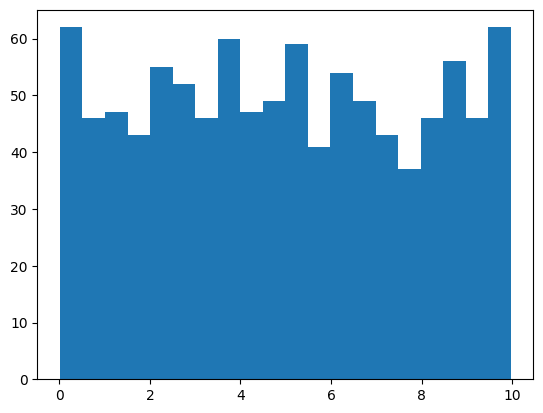

In [48]:
# generate 10000 samples of a uniform distribution
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

x = np.random.uniform(0,10,1000)
plt.hist(x, bins=20)

(array([  6.,  25.,  74., 162., 221., 204., 179.,  94.,  28.,   7.]),
 array([-3.03772489, -2.43496637, -1.83220785, -1.22944933, -0.6266908 ,
        -0.02393228,  0.57882624,  1.18158476,  1.78434328,  2.3871018 ,
         2.98986032]),
 <BarContainer object of 10 artists>)

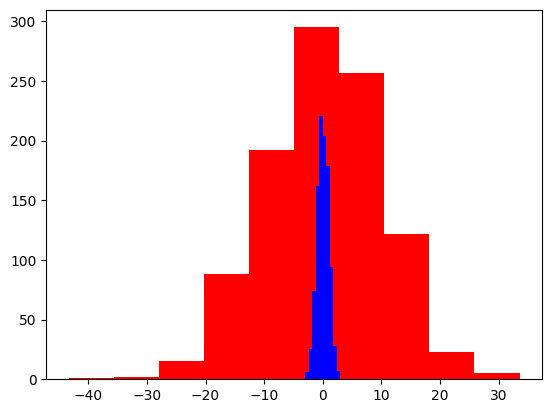

In [91]:
# generate 1000 samples from a Gaussian distributions and plot
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

x = np.random.normal(0,10,1000)
y = np.random.normal(0,1,1000)

plt.hist(x,color="red")
plt.hist(y,color="blue")

In [8]:
from scipy import stats
t = -1.32
print(stats.t.cdf(t,df=11))
print(stats.t.ppf(0.95,df=11)) # the inverse of CDF


0.10682233239922606
1.7958848187036691


Probability to get 1.96 is: 0.058440944333451476
Probability to be less than 1.96 is: 0.9750021048517795


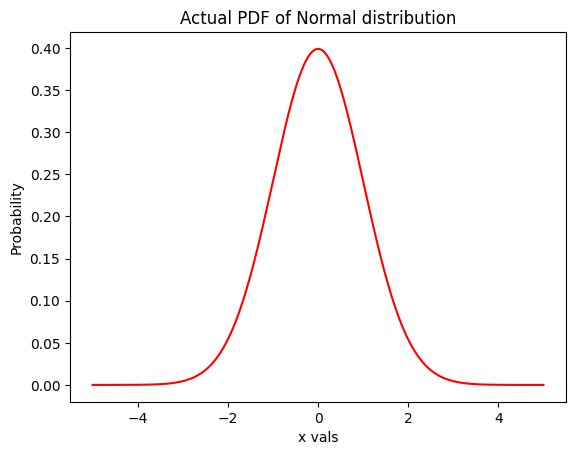

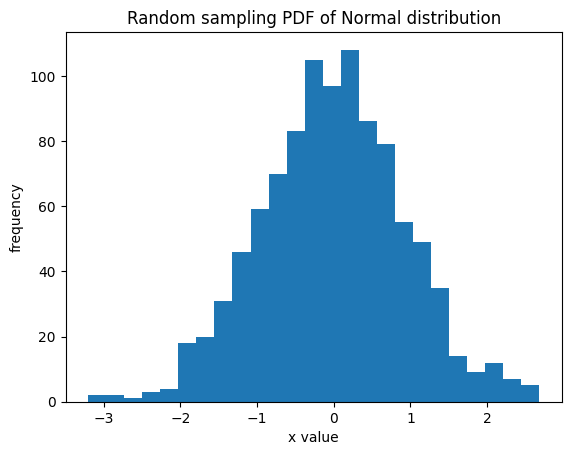

In [89]:
#generate 1000 random samples of normal distribution
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np

mean=0
std=1
normal_dist = stats.norm(mean,std)

print("Probability to get 1.96 is: {}".format(normal_dist.pdf(1.96)))
print("Probability to be less than 1.96 is: {}".format(normal_dist.cdf(1.96)))

y = np.linspace(-5,5,1000)
plt.plot(y,normal_dist.pdf(y),color="r")
plt.xlabel('x vals')
plt.ylabel('Probability')
plt.title('Actual PDF of Normal distribution')
plt.show()

normal_dist.random_state=10
x = normal_dist.rvs(1000)

plt.hist(x,bins=25)
plt.xlabel("x value")
plt.ylabel("frequency")
plt.title("Random sampling PDF of Normal distribution")
plt.show()

[ 8 24 67 87 79 48 10 94 52 98 53 66 98 14 34 24 15 60 58 16  9 93 86  2
 27  4 31  1 13 83]
45.13333333333333
32.87018236774613


Text(0, 0.5, 'count')

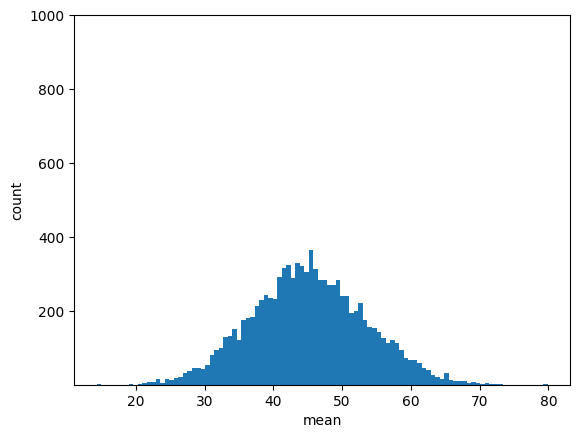

In [49]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(100)
# a = [np.random.randint(100) for i in range(10)]
b = np.random.randint(0,100,30)
# print(a)
print(b)
print(np.mean(b))
print(np.std(b))

arr = []
for i in range(10000):
  sample = np.random.choice(b,15)
  arr.append(np.mean(sample))

plt.hist(arr,bins=100)
plt.ylim(1,1000)
plt.xlabel("mean")
plt.ylabel('count')

In [26]:
from scipy import stats
df = 24
t = -2.5
print(stats.t.cdf(t,df)) #calc p-value based on t-score
print(stats.t.ppf(0.95,df)) #calc t-score based on p-value (quantile)
print(stats.norm.cdf(1.96)) # clac p-value based on z-score
print(stats.norm.ppf(0.98)) #calc z-score based on p-value (quantile)

0.009827087558289377
1.7108820799094275
0.9750021048517795
2.0537489106318225


In [6]:
from scipy import stats
df = 5
t = 2.75
print(stats.t.cdf(t,df))
print(stats.norm.cdf(1.83))
print(stats.norm.ppf(0.995))

0.9798448887299873
0.9663750305803717
2.5758293035489004


In [4]:
from scipy import stats
print(stats.chi2.cdf(11.44,5))

0.9566787520573562


In [56]:
# self made example of linear regression model - sample function - Y = 3*x + 2
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(100)
x = np.random.rand(100) *10
y = [xi * np.random.normal(3,0.5) + np.random.normal(2,0.2) for xi in x]

epochs = 300000
lr = 0.0001
a = 0
b = 0
error = 0
for epoch in range(epochs):
  y_pred = x*a + b
  diff = y_pred - y
  cost_a = 2.0/len(x) * np.sum(diff * x)
  cost_b = 2.0/len(x) * np.sum(diff)
  a = a - lr*cost_a
  b = b - lr*cost_b
  if epoch % 10000 == 0:
    print("function is: y = {}x + {}".format(a,b))
print("FINAL function is: y = {}x + {}".format(a,b))

function is: y = 0.020761759957998338x + 0.00329769864581652
function is: y = 3.2207417108416525x + 1.0657527775291957
function is: y = 3.1703988117879756x + 1.389871611011369
function is: y = 3.1408446137136132x + 1.5801481422486632
function is: y = 3.1234945873894038x + 1.691851488674798
function is: y = 3.1133091168618807x + 1.7574278239257102
function is: y = 3.107329655624856x + 1.7959249315104346
function is: y = 3.1038193654926056x + 1.8185249637738894
function is: y = 3.1017586218362574x + 1.8317924919170212
function is: y = 3.100548845932506x + 1.8395812995158984
function is: y = 3.0998386373955116x + 1.8441537807767527
function is: y = 3.099421703842399x + 1.8468380921575966
function is: y = 3.0991769396940465x + 1.8484139384384861
function is: y = 3.0990332489599415x + 1.84933905149307
function is: y = 3.098948894175115x + 1.8498821464472825
function is: y = 3.0988993730298047x + 1.8502009746465224
function is: y = 3.0988703012487835x + 1.8503881452689839
function is: y = 3.